In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings # 0 warnings :)
warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz

In [2]:
df = pd.read_csv('electricity.csv')
df.drop_duplicates()
df = df.dropna()
df['Utility.State'] = df['Utility.State'].astype('category')
df['Utility.Type'] = df['Utility.Type'].astype('category')
df = df.rename(columns={'Demand.Summer Peak': 'Demand.SummerPeak', 'Demand.Winter Peak': 'Demand.WinterPeak', 'Uses.No Charge':'Uses.NoCharge'})


### Winter Peak Tree

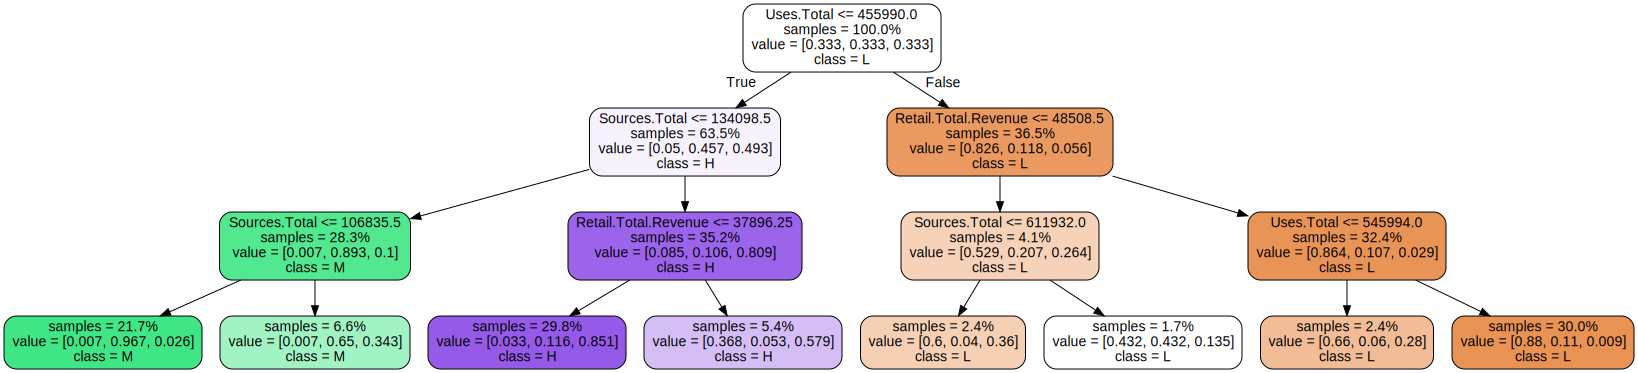

In [3]:
df_WinterPeak = pd.DataFrame()
df_WinterPeak['Ranking'] = pd.qcut(df['Demand.WinterPeak'], q =3, labels = ["L","M","H"])
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_WinterPeak['Ranking']
Tree = tree.DecisionTreeClassifier(max_depth = 3)
Tree.fit(attributes, target)
dot_data = tree.export_graphviz(Tree,
                               out_file=None,
                               feature_names=attributes.columns,
                               class_names = ["L","M","H"],
                               proportion=True,
                               impurity=False,
                               filled=True,
                               rounded=True)
graph = graphviz.Source(dot_data)
#graph.render('WinterPeakTree')
graph

### Summer Peak Tree

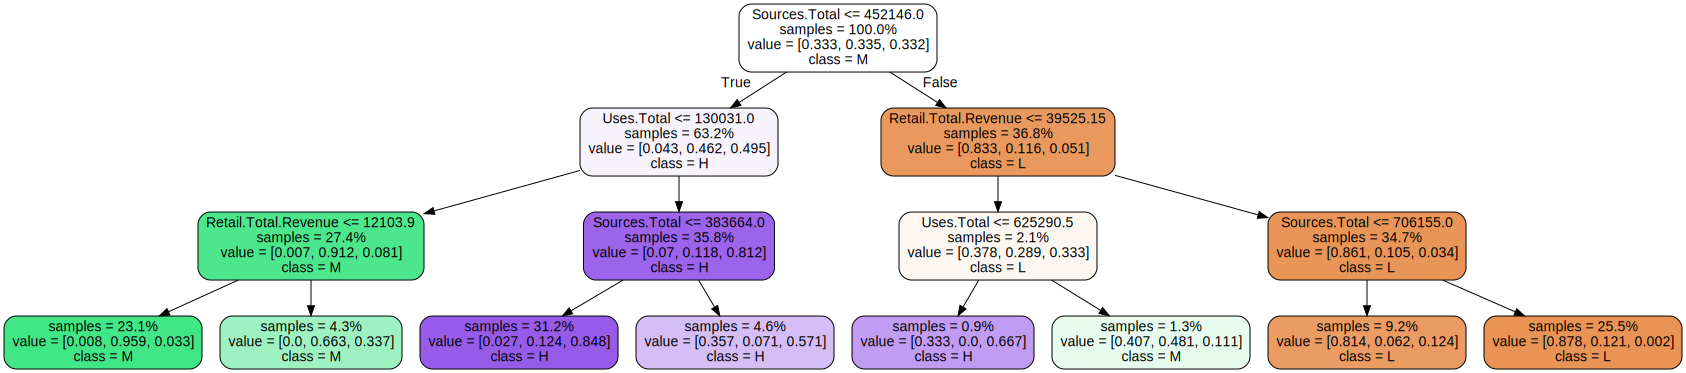

In [4]:
df_SummerPeak = pd.DataFrame()
df_SummerPeak['Ranking'] = pd.qcut(df['Demand.SummerPeak'], q =3, labels = ["L","M","H"])
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_SummerPeak['Ranking']
Tree = tree.DecisionTreeClassifier(max_depth = 3)
Tree.fit(attributes, target)
dot_data = tree.export_graphviz(Tree,
                               out_file=None,
                               feature_names=attributes.columns,
                               class_names = ["L","M","H"],
                               proportion=True,
                               impurity=False,
                               filled=True,
                               rounded=True)
graph = graphviz.Source(dot_data)
#graph.render('SummerPeakTree')
graph

### Find best winter peak tree

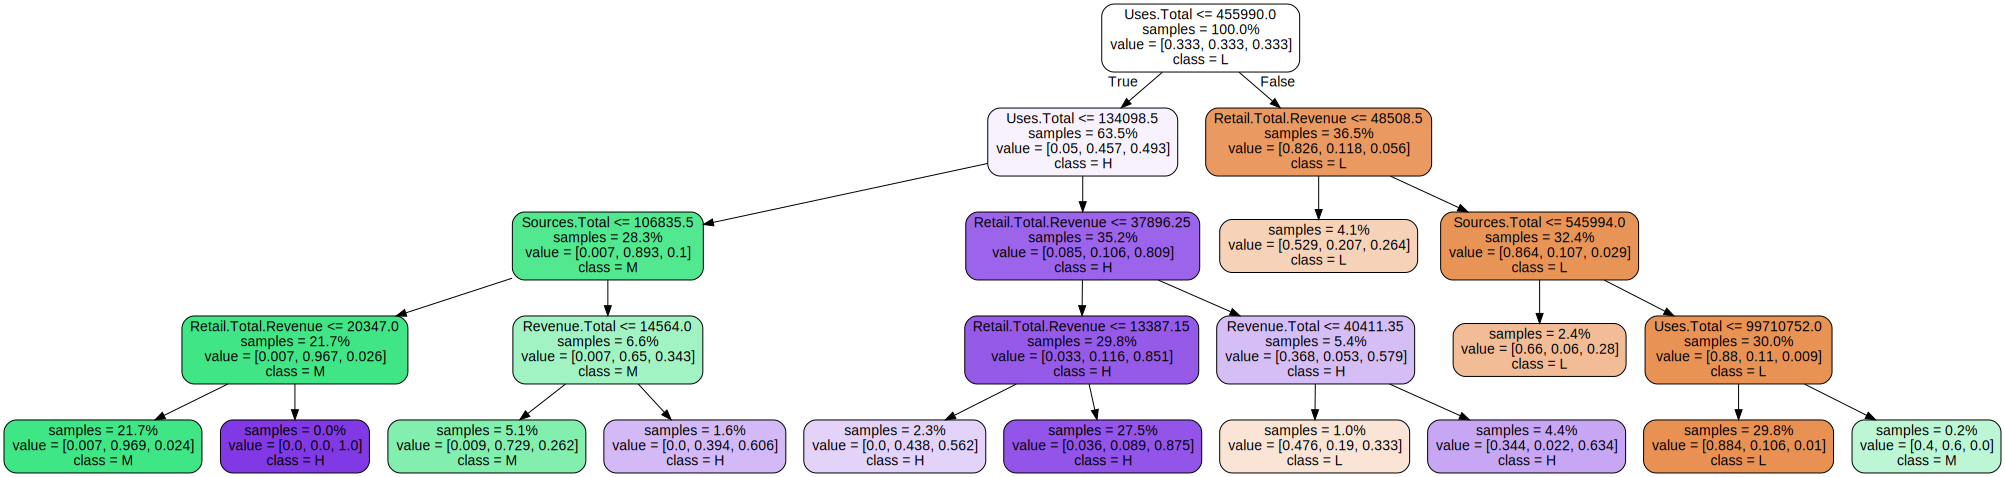

In [5]:
parameters = {'max_depth': [2,3,4,5,6], 'min_samples_split':[50,60,70,80,85,86,87,88,89,90,91,92,93,95,100,110,120]}
Tree = tree.DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid = parameters, n_jobs = -1)
### calculation
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_WinterPeak['Ranking']
TreeCV.fit(attributes, target)
TreeCV.best_params_
dot_data = tree.export_graphviz(TreeCV.best_estimator_,
            out_file=None,
            feature_names=attributes.columns,
            class_names = df_WinterPeak['Ranking'].cat.categories,
            proportion=True,
            impurity=False,
            filled=True,
            rounded=True)
winter_best = graphviz.Source(dot_data)
# graph.render('WinterPeakUsage-best')
winter_best

### Find the best Summer Peak Tree

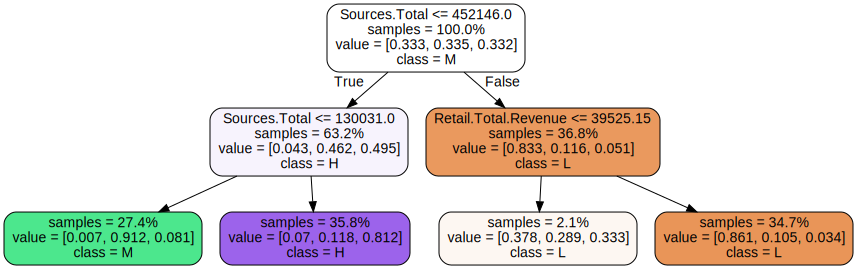

In [6]:
parameters = {'max_depth': [1,2,3,4,5,6], 'min_samples_split':[1,2,3,4,5,6,7,10,20,30,40,50,60,70,80,85,86]}
Tree = tree.DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid = parameters, n_jobs = -1)
### calculation
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_SummerPeak['Ranking']
TreeCV.fit(attributes, target)
TreeCV.best_params_
dot_data = tree.export_graphviz(TreeCV.best_estimator_,
            out_file=None,
            feature_names=attributes.columns,
            class_names = df_SummerPeak['Ranking'].cat.categories,
            proportion=True,
            impurity=False,
            filled=True,
            rounded=True)
summer_best = graphviz.Source(dot_data)
#graph.render('SummerPeakUsage-best')
summer_best

### Naive Bayes on Summer Peak

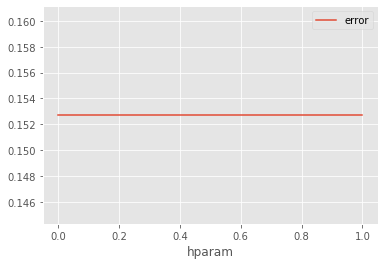

In [7]:
df_resample = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
attributes = df_resample[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_resample['Demand.SummerPeak']
target = pd.qcut(target,q=2,labels=['L','H'])
for j in range(attributes.shape[1]):
    attributes.iloc[:,j] = pd.qcut(attributes.iloc[:,j],q=3,labels=['S','M','L'])
# attributes.head(3)
attributes = pd.get_dummies(attributes)
hparam = {'alpha':[10**(-10),0.1,0.2,0.3,0.4,1]}
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes, param_grid = hparam)
NBayesCV.fit(attributes, target)
results = pd.DataFrame()
results['hparam'] = hparam['alpha']
results['error']  = 1 - NBayesCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [8]:
NBayesCV.best_params_
error_bayes = 1 - NBayesCV.best_score_
print('Navie Bayes validation error rate: ', error_bayes.round(3))

Navie Bayes validation error rate:  0.153


### Logistic Regression on Summer Peak 

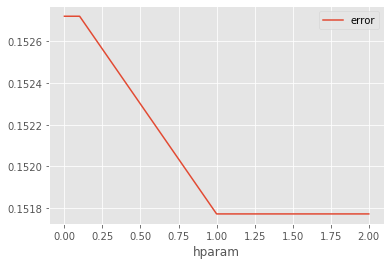

In [9]:
lgr = LogisticRegression()
hparam = {'C' : [0.0001,0.001,0.01,0.1,1,2]}
lgrCV = GridSearchCV(lgr, param_grid = hparam)
lgrCV.fit(attributes, target)
results = pd.DataFrame()
results['hparam'] = hparam['C']
results['error']  = 1 - lgrCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [10]:
error_logistic = 1 - lgrCV.best_score_
print('Logistic regression validation error rate: ', error_logistic.round(3))

Logistic regression validation error rate:  0.152


### Decision Tree on Summer Peak 

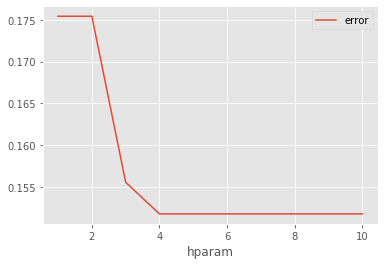

In [11]:
hparam = {'max_depth' : [1,2,3,4,5,6,7,8,9,10]}
Tree = DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid = hparam)
TreeCV.fit(attributes, target)
results = pd.DataFrame()
results['hparam'] = hparam['max_depth']
results['error']  = 1 - TreeCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [12]:
error_tree = 1- TreeCV.best_score_
print('Tree validation error rate: ', error_tree.round(3))

Tree validation error rate:  0.152


### Trying some interactive stuff

In [40]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from IPython.display import SVG
import pydotplus

input_slider = widgets.IntSlider(value=3,min=0,max=10,description='Max_depth:')
def identity(x):
    return x
interact(identity, x=input_slider)

interactive(children=(IntSlider(value=3, description='Max_depth:', max=10), Output()), _dom_classes=('widget-i…

<function __main__.identity(x)>

In [52]:
## trying with a winter decision tree
df_WinterPeak = pd.DataFrame()
df_WinterPeak['Ranking'] = pd.qcut(df['Demand.WinterPeak'], q =2, labels = ["L","H"])
attributes = df[['Sources.Total','Uses.Total','Revenue.Total','Retail.Total.Revenue']]
target = df_WinterPeak['Ranking']

def win_tree(x):
    Tree = tree.DecisionTreeClassifier(max_depth = x)
    Tree.fit(attributes, target)
    dot_data = tree.export_graphviz(Tree,
                                   out_file=None,
                                   feature_names=attributes.columns,
                                   class_names = ["L","H"],
                                   proportion=True,
                                   impurity=False,
                                   filled=True,
                                   rounded=True)
    #src = graphviz.Source(dot_data)
    #return display(SVG(src.pipe(format='svg')))
    # return graph
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"5,20!"')
    # return pydot_graph
    gvz_graph = graphviz.Source(pydot_graph.to_string())
    return gvz_graph
    
input_slider = widgets.IntSlider(value=3,min=1,max=6,description='Max_depth:')
interact(win_tree, x=input_slider)

interactive(children=(IntSlider(value=3, description='Max_depth:', max=6, min=1), Output()), _dom_classes=('wi…

<function __main__.win_tree(x)>